In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import meep.adjoint as mpa
from autograd import numpy as npa

mp.verbosity(0)


1

In [2]:
a = 0.775
r,h,wl, = 0.315*a,0.3,1.55
x_num,y_num = 20,6
wg_wight = y_num*np.sqrt(3)*a*2

kpoint = mp.Vector3(1,0,0)


block_x,block_y,block_z=0,0,0
Block_x,Block_y,Block_z=x_num*a,wg_wight,h

x_length = 3 
y_length = np.sqrt(3)*a
z_length = h

block_x1= -x_num*0.5*a-x_length*0.5
block_x2= -block_x1

aa=4
resolution = 10  # pixels/um

dpml = 1.0
pml_layers = [mp.PML(dpml)]

sx = Block_x + 2 * x_length + 2*aa + 2*dpml  # size of cell in X direction
sy = Block_y + 2*dpml  # size of cell in Y direction
sz = 2*dpml + 5*h
cell = mp.Vector3(sx, sy, sz)

nfreq = 100  # number of frequencies at which to compute flux
fcen = 1/wl  # pulse center frequency
df = 0.1  # pulse width (in frequency)

source_center=mp.Vector3(-sx/2+2, 0, 0)
refl_monitor=mp.Vector3(block_x+aa-Block_x/2 - 1,0,0)
trans_monitor=mp.Vector3(sx/2-dpml-1,0,0)

source_size=mp.Vector3(0, 2*y_length, 3*h)


def lno(a):
    b = 1+2.6734*a**2/(a**2-0.01764)+1.2290*a**2/(a**2-0.0591)+12.614*a**2/(a**2-474.60)
    return b
def lne(a):
    b = 1+2.9804*a**2/(a**2-0.02047)+0.5981*a**2/(a**2-0.0666)+8.9543*a**2/(a**2-416.08)
    return b


def add_cylinder(local):
    a = mp.Cylinder(radius=r,height=h,center=local,material=mp.air)
    return a


LN = mp.Medium(epsilon_diag=(lno(wl),lne(wl),lno(wl)))




In [3]:


def phc_wg() -> mpa.OptimizationProblem:



    geometry = [mp.Block(size=mp.Vector3(mp.inf,y_length, z_length),
                        center=mp.Vector3(block_x1,0),material=LN),]

    geometry += [mp.Block(size=mp.Vector3(Block_x,Block_y, z_length),
                        center=mp.Vector3(block_x+aa,block_y),material=LN)]

    for i in np.linspace(-x_num*0.5*a,x_num*0.5*a,x_num+1):
        for j in np.linspace(-y_num*np.sqrt(3)*a,y_num*np.sqrt(3)*a,2*y_num+1):
            if j != 0:
                geometry += [add_cylinder(mp.Vector3(i+0.5*a+aa,j,0)),
                            add_cylinder(mp.Vector3(i+aa,j+np.sqrt(3)*0.5*a,0))]
            else:
                geometry += [add_cylinder(mp.Vector3(i+aa,np.sqrt(3)*0.5*a,0))]


    src = mp.GaussianSource(frequency=fcen,fwidth=df)
    sources = [mp.EigenModeSource(src,
                        eig_band = 1,
                        direction=mp.AUTOMATIC,
                        eig_kpoint=kpoint,
                        size = source_size,
                        center=source_center,
                        ),
                        
                        ]

    ########################################################

    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=sources,
        resolution=resolution,
        default_material=mp.air,
    )




    mode = 1



    TE_refl = mpa.EigenmodeCoefficient(sim,
            mp.Volume(center=refl_monitor,
                size=source_size),mode, forward=False,)

    TE_trans = mpa.EigenmodeCoefficient(sim,
            mp.Volume(center=trans_monitor,
                size=source_size),mode)

    ob_list = [TE_refl, TE_trans]

    def J(a,b):
        power = npa.abs(a) **2
        return power

    opt = mpa.OptimizationProblem(
        simulation = sim,
        objective_functions = J,
        objective_arguments = ob_list,
        design_regions = [],
        #frequencies=frequencies,
        fcen=fcen,
        df=df,
        nf=nfreq,
    )
    return opt

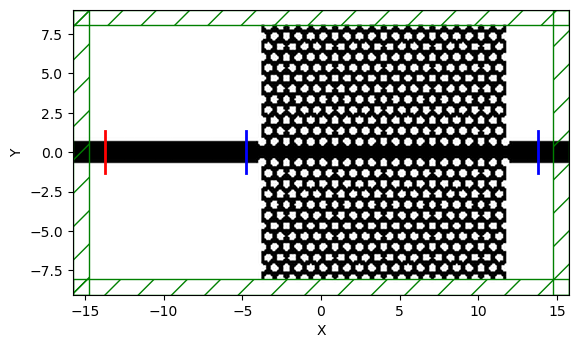

In [4]:
simulation=phc_wg()

simulation.plot2D(True, output_plane = mp.Volume(
        center = mp.Vector3(z=0.0),
        size = mp.Vector3(x=sx,y=sy)
    ))

In [5]:
f0, dJ_du = simulation(need_gradient = False)
#frequencies = simulation.frequencies
refl_coef, trans_coef = simulation.get_objective_arguments()

Starting forward run...


In [10]:
frequencies = simulation.frequencies


In [36]:
refl_profile = np.abs(refl_coef) ** 2 
trans_profile = np.abs(trans_coef) **2 

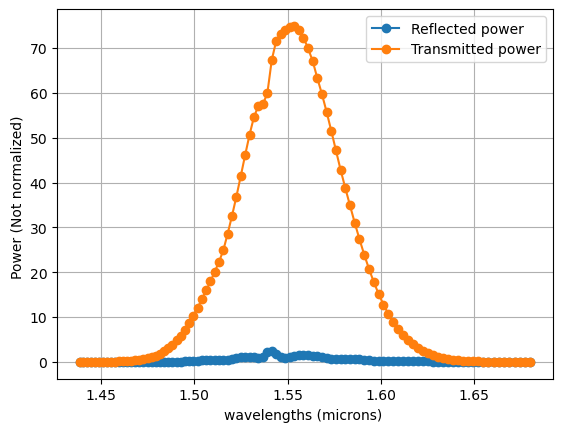

In [37]:
plt.figure()
plt.plot(1/frequencies,refl_profile,'-o' ,label = 'Reflected power')
plt.plot(1/frequencies,trans_profile,'-o',label = 'Transmitted power')


plt.legend()
plt.grid(True)
plt.xlabel('wavelengths (microns) ')

plt.ylabel('Power (Not normalized) ')
plt.show()

In [23]:


def straight_wg() -> mpa.OptimizationProblem:


    sx = 8
    sy = 4*y_length

    source_center=mp.Vector3(-sx/2+2, 0, 0)
    trans_monitor=mp.Vector3(sx/2-dpml-1,0,0)

    geometry = [
        mp.Block(
            size=mp.Vector3(mp.inf, y_length, z_length),
            center=mp.Vector3(0, 0, 0),
            material=LN,
        )
    ]


    src = mp.GaussianSource(frequency=fcen,fwidth=df)
    sources = [mp.EigenModeSource(src,
                        eig_band = 1,
                        direction=mp.AUTOMATIC,
                        eig_kpoint=kpoint,
                        size = source_size,
                        center=source_center,
                        ),
                        
                        ]




    sim = mp.Simulation(
        cell_size = mp.Vector3(sx, sy, sz),
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=sources,
        resolution=resolution,
        default_material=mp.air,
    )


    mode = 1



    TE_trans = mpa.EigenmodeCoefficient(sim,
            mp.Volume(center=trans_monitor,
                size=source_size),mode)

    ob_list = [ TE_trans]

    def J(a):
        power = npa.abs(a) **2
        return power

    opt = mpa.OptimizationProblem(
        simulation = sim,
        objective_functions = J,
        objective_arguments = ob_list,
        design_regions = [],
        #frequencies=frequencies,
        fcen=fcen,
        df=df,
        nf=nfreq,
    )
    return opt

/home/satadrudas/anaconda3/envs/meep/lib/python3.11/site-packages/meep/visualization.py:271: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


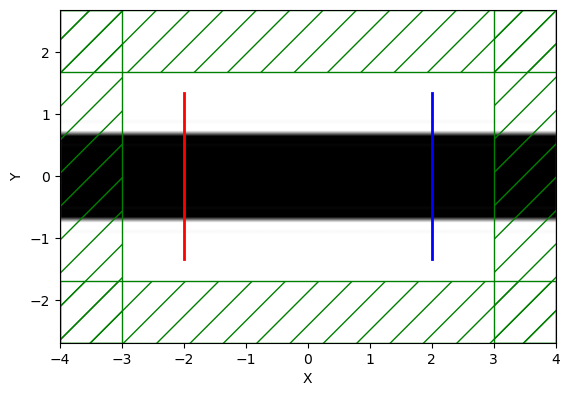

In [24]:
simulation2=straight_wg()

simulation2.plot2D(True, output_plane = mp.Volume(
        center = mp.Vector3(z=0.0),
        size = mp.Vector3(x=sx,y=sy)
    ))

In [25]:
f0, dJ_du = simulation2(need_gradient = False)
frequencies2 = simulation2.frequencies
norm_coef = simulation2.get_objective_arguments()

Starting forward run...


In [26]:
refl_profile = np.abs(refl_coef) ** 2 / np.abs(norm_coef) ** 2 
trans_profile = np.abs(trans_coef) **2 / np.abs(norm_coef) ** 2 

In [27]:
refl_profile=np.reshape(refl_profile, (100,))
trans_profile=np.reshape(trans_profile, (100,))

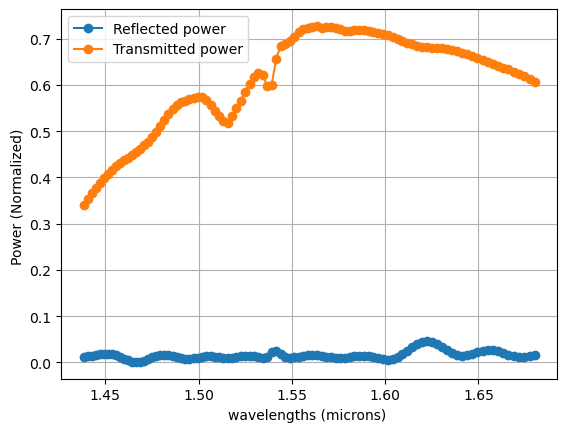

In [35]:
plt.figure()
plt.plot(1/frequencies2,refl_profile,'-o' ,label = 'Reflected power')
plt.plot(1/frequencies2,trans_profile,'-o',label = 'Transmitted power')


plt.legend()
plt.grid(True)
plt.xlabel('wavelengths (microns) ')

plt.ylabel('Power (Normalized) ')
plt.show()